# Attention tokens

In [5]:
import torch
from transformer_lens import HookedTransformer, SVDInterpreter

device = torch.device("cpu")
if torch.cuda.is_available():
    device = torch.device("cuda")
elif torch.backends.mps.is_available():
    device = torch.device("mps")

torch.cuda.empty_cache()
torch.set_grad_enabled(False)

# NBVAL_IGNORE_OUTPUT
model = HookedTransformer.from_pretrained(
    "gpt2-small",
    center_unembed=True,
    center_writing_weights=True,
    fold_ln=True,
    refactor_factored_attn_matrices=True,
)

Loaded pretrained model gpt2-small into HookedTransformer


In [6]:
import random
import numpy as np
from itertools import permutations, product
import einops
from fancy_einsum import einsum
from rich import print
from IPython.display import HTML
from circuitsvis.attention import attention_heads
from transformer_lens.utils import Slice
from plotly import express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import plotly.io as pio
pio.renderers.default = "png"

In [7]:
def decompose_head(cache, l, h, pos=None):
    start, end = 0, len(cache['q', l][0])
    if pos is not None:
        start, end = pos
    q = cache['q', l][:, start:end, h, :]
    k = cache['k', l][:, start:end, h, :]
    v = cache['v', l][:, start:end, h, :]
    return torch.stack([q, k, v])

def project_attn(cache, l, h, mlp=True, **kwargs):
    OV = cache.model.OV[l, h]
    mlp_in = model.W_in[l]
    mlp_out = model.W_out[l]

    cs = decompose_head(cache, l, h, **kwargs)
    proj_A = torch.einsum('c b i h, d h -> c b i d', cs, OV.A)
    proj_B = torch.einsum('c b i d, h d -> c b i d', proj_A, OV.B)
    out = proj_B
    if mlp:
        mlped = torch.einsum('c b i d, d j -> c b i j', proj_B, mlp_in)
        mlped_out = torch.einsum('c b i j, j d -> c b i d', mlped, mlp_out)
        out = mlped_out
    return out

def head2logits(cache, l, h, **kwargs):
    projections = project_attn(cache, l, h, **kwargs)
    logits = cache.model.unembed(projections)
    return logits

In [174]:
def head2preds(cache, hp, l, h, k=1):
    OV = cache.model.OV[l, h]
    proj_A = torch.einsum('b n m h, d h -> b n m d', hp, OV.A)
    proj_B = torch.einsum('b n m d, h d -> b n m d', proj_A, OV.B)
    out = proj_B
    logits = cache.model.unembed(out[0])
    preds = torch.topk(logits, k, dim=-1).indices
    return preds

def plot_attention_head(cache, layer, head, cmap='Inferno', **kwargs):
    print(f'Plotting attention head {head} at layer {layer}')
    patterns = cache['attn', layer][:, head, :, :]
    sequence_length = patterns.shape[-1]
    pattern = patterns.mean(dim=0)
    normalized_pattern = (pattern - pattern.min()) / (pattern.max() - pattern.min())
    print(f'Pattern: {normalized_pattern.shape}')
    # Assuming decompose_head and other model-related functions are defined elsewhere
    q, k, v = decompose_head(cache, layer, head)
    hp = q.unsqueeze(2) * k.unsqueeze(1)

    preds = head2preds(cache, hp, layer, head, **kwargs)
    str_preds = [cache.model.to_str_tokens(p) for p in preds]

    for i in range(len(str_preds)):
        for j in range(len(str_preds[i])):
            t = str_preds[i][j]
            if t == '\n':
                str_preds[i][j] = '<nl>'
            if t == ' ':
                str_preds[i][j] = '<sp>'
            if t == '\t':
                str_preds[i][j] = '<tab>'
            if t == '<|endoftext|>':
                str_preds[i][j] = 'EOS'

    # Create a unique list of tokens, maintaining the order they first appear
    unique_tokens= []
    for i in range(0, sequence_length):
        for j in range(i + 1):
            token = str_preds[i][j]
            if token not in unique_tokens:
                unique_tokens.append(token)

    token_to_int = {token: i for i, token in enumerate(unique_tokens)}
    
    print(f'Sequence length: {sequence_length}')
    print(f'Unique tokens: {len(unique_tokens)}')
    print(f'str preds: {str_preds}')
    print(f'Unique tokens: {unique_tokens}')
    # Generate a new matrix with integers representing tokens
    token_matrix = torch.zeros((sequence_length, sequence_length)).to(device)
    for i in range(sequence_length):
        for j in range(i + 1):
            token = str_preds[i][j]
            token_matrix[i, j] = token_to_int[token]

    fig = px.imshow(
        token_matrix.cpu(),
        color_continuous_scale=cmap,
        color_continuous_midpoint=0.5,
        title=f'Attention head {head} at layer {layer}',
    )
    input_tokens = cache.model.to_str_tokens(random.choice(cache.prompts))

    for i in range(len(input_tokens)):
        t = input_tokens[i]
        if t == '\n':
            input_tokens[i] = '<nl>'
        if t == ' ':
            input_tokens[i] = '<sp>'
        if t == '\t':
            input_tokens[i] = '<tab>'
        if t == '<|endoftext|>':
            input_tokens[i] = 'EOS'
    min_opacity = 0.3
    for i in range(sequence_length):
        fig.add_annotation(x=-1, y=i, text=input_tokens[i], showarrow=False, xshift=0, yshift=0, font=dict(size=16, color='black'))
        fig.add_annotation(x=i, y=sequence_length, text=input_tokens[i], showarrow=False, xshift=0, yshift=0, font=dict(size=16, color='black'))
        for j in range(i + 1):
            opacity = max(min(pattern[i, j].item() + min_opacity, 1), min_opacity)
            fig.add_annotation(
                x=j,
                y=i,
                text=str_preds[i][j],
                showarrow=False,
                font=dict(color="white"),
                opacity=opacity,
            )
    
    fig.update_coloraxes(showscale=False)
    fig.update_layout(
        width=1200, height=1200,
        plot_bgcolor='white',
        xaxis=dict(showticklabels=False),
        yaxis=dict(showticklabels=False, autorange='reversed'),
    )

    return fig, unique_tokens

In [158]:
def run_prompt(model, *prompts):
    _, cache = model.run_with_cache(list(prompts))
    cache.prompts = list(prompts)
    return cache

def plot_prompts(cache, l, h):
    fig = plot_attention_head(cache, l, h, cmap='viridis')
    return fig

In [128]:
cache = run_prompt(model, 'John was two years older than Mary. Who was born first? John was born before Mary')
cache.prompts

['John was two years older than Mary. Who was born first? John was born before Mary']

Plotting attention head 1 at layer 0

Pattern: torch.Size([14, 14])

q_preds: [[' the', ',', '.', ' and', ' a', ' in', ' to', '\n', ' of', '-', "'s", ' for', ' at', ' "'], [' the', 
',', '.', ' and', ' a', ' in', ' to', "'s", '-', '\n', ' for', ' that', ' as', ' at'], [' the', ',', '.', ' and', '
a', ' in', ' to', ' as', ' for', "'s", '\n', ' on', ' at', ' of'], [',', ' the', '.', ' a', "'s", ' and', ' in', ' 
to', ' on', '\n', ' as', '-', ' for', ' that'], ['.', ',', ' the', ' a', ' and', '\n', ' in', ' as', ' of', ' to', 
'-', ' that', ':', ' on'], [',', ' the', '.', ' a', ' and', ' in', ' to', '\n', ' at', ' as', ' "', '-', ':', ' 
on'], [' the', ',', '.', ' a', ' to', ' and', ' in', ' that', ' of', '\n', ' for', ' "', ' at', ' one'], [',', ' 
the', ' and', '.', "'s", '-', ' a', ' in', ' to', ' "', ' for', ' of', '\n', ' that'], [' the', ',', '.', ' and', '
a', ' to', '\n', ' in', ' of', ' "', '-', ' that', ' (', ' for'], [' the', ',', '.', ' a', ' in', ' and', ' to', 
'\n', ' as', ' on', ' of', '-', ' The', ' one'], [',', ' the', '.', ' a', ' and', ' in', "'s", ' to', ' on', '\n', 
' as', '-', ' for', ' that'], [' the', '.', ',', ' and', ' a', '\n', ' in', ' of', '-', ' to', ' as', ' that', ':',
' ('], [' the', ',', '.', ' a', "'s", ' and', '\n', ' in', ' to', '-', ' as', ' that', ' for', ':'], [',', ' the', 
' and', '.', "'s", '-', ' a', ' in', ' to', ' "', ' of', ' for', '\n', ' that']]

Sequence length: 14

Unique tokens: 16

str preds: [[' the', '<nl>', ' of', ' of', 'gp', ' of', '<nl>', ' of', 'st', 'gp', ' of', 'gp', 'gp', ' of'], [' 
the', '12', ' and', '<nl>', '12', '12', '<nl>', 'e', 'gp', 'gp', 'H', 'gp', 'gp', 'gp'], [' the', '12', ' of', 
'<nl>', 'gp', 'gp', 'e', 'gp', 'gp', 'gp', 'gp', 'gp', 'gp', 'gp'], [',', '12', 'e', '<nl>', 'gp', 'gp', 'c', 'gp',
'gp', 'gp', 'gp', 'gp', 'gp', 'gp'], [',', ' of', 'e', '<nl>', 'gp', 'gp', 'x', 'gp', 'gp', 'gp', 'gp', 'gp', 'gp',
'gp'], [' the', '<nl>', ' of', 'st', 'gp', 'gp', 'gp', 'gp', 'gp', 'gp', 'gp', 'gp', 'gp', 'gp'], [' the', '<nl>', 
'e', '<nl>', 'gp', 'e', ' in', '<nl>', 'gp', 'e', 'gp', 'gp', 'gp', 'gp'], [',', 'st', ' of', ' of', 'gp', 'gp', ' 
of', 'tg', 'gp', 'gp', 'gp', 'gp', 'gp', 'gp'], [' the', ' of', '<nl>', '<nl>', 'gp', 'e', ' of', 'e', 'gp', 'gp', 
'H', 'gp', 'gp', 'gp'], [' the', '<nl>', ' a', '<nl>', 'e', 'e', 'e', 'st', '80', 'Dim', 'e', 'gp', 'gp', 'st'], 
[',', '<nl>', 'e', '<nl>', 'gp', 'gp', '<nl>', 'gp', 'st', 'gp', 'gp', 'gp', 'gp', 'gp'], [',', ' of', ' of', 
'<nl>', 'gp', 'gp', 'x', 'gp', 'gp', 'gp', 'gp', 'gp', 'gp', 'gp'], [' the', '<nl>', '<nl>', ' and', 'e', 'gp', 
'<nl>', '<nl>', 'gp', 'gp', 'gp', 'gp', 'gp', '<nl>'], [',', ' of', ' of', ' of', 'gp', 'gp', ' of', 'c', 'gp', 
'gp', 'st', 'gp', 'gp', 'gp']]

Unique tokens: [' the', '12', ' of', ',', 'e', '<nl>', 'gp', 'st', ' in', 'tg', ' a', '80', 'Dim', 'x', ' and', 
'c']

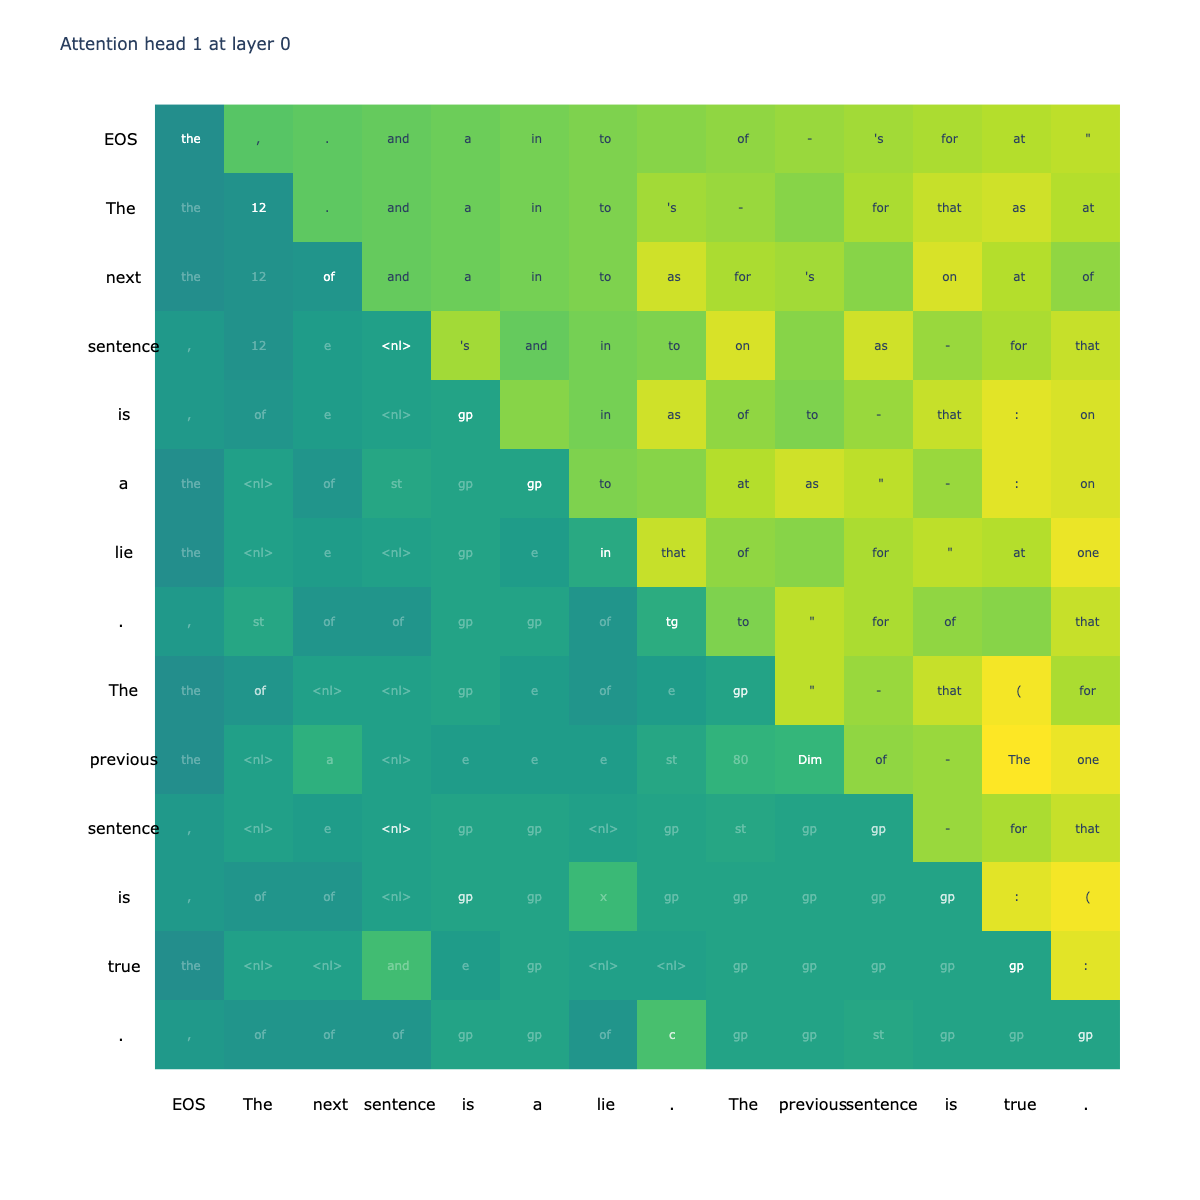

In [140]:
fig, _ = plot_prompts(cache, 0, 1)
fig.show()

Plotting attention head 1 at layer 0

Pattern: torch.Size([14, 14])

q_preds: [[' the', ',', '.', ' and', ' a', ' in', ' to', '\n', ' of', '-', "'s", ' for', ' at', ' "'], [' the', 
',', '.', ' and', ' a', ' in', ' to', "'s", '-', '\n', ' for', ' that', ' as', ' at'], [' the', ',', '.', ' and', '
a', ' in', ' to', ' as', ' for', "'s", '\n', ' on', ' at', ' of'], [',', ' the', '.', ' a', "'s", ' and', ' in', ' 
to', ' on', '\n', ' as', '-', ' for', ' that'], ['.', ',', ' the', ' a', ' and', '\n', ' in', ' as', ' of', ' to', 
'-', ' that', ':', ' on'], [',', ' the', '.', ' a', ' and', ' in', ' to', '\n', ' at', ' as', ' "', '-', ':', ' 
on'], [' the', ',', '.', ' a', ' to', ' and', ' in', ' that', ' of', '\n', ' for', ' "', ' at', ' one'], [',', ' 
the', ' and', '.', "'s", '-', ' a', ' in', ' to', ' "', ' for', ' of', '\n', ' that'], [' the', ',', '.', ' and', '
a', ' to', '\n', ' in', ' of', ' "', '-', ' that', ' (', ' for'], [' the', ',', '.', ' a', ' in', ' and', ' to', 
'\n', ' as', ' on', ' of', '-', ' The', ' one'], [',', ' the', '.', ' a', ' and', ' in', "'s", ' to', ' on', '\n', 
' as', '-', ' for', ' that'], [' the', '.', ',', ' and', ' a', '\n', ' in', ' of', '-', ' to', ' as', ' that', ':',
' ('], [' the', ',', '.', ' a', "'s", ' and', '\n', ' in', ' to', '-', ' as', ' that', ' for', ':'], [',', ' the', 
' and', '.', "'s", '-', ' a', ' in', ' to', ' "', ' of', ' for', '\n', ' that']]

Sequence length: 14

Unique tokens: 16

str preds: [[' the', '<nl>', ' of', ' of', 'gp', ' of', '<nl>', ' of', 'st', 'gp', ' of', 'gp', 'gp', ' of'], [' 
the', '12', ' and', '<nl>', '12', '12', '<nl>', 'e', 'gp', 'gp', 'H', 'gp', 'gp', 'gp'], [' the', '12', ' of', 
'<nl>', 'gp', 'gp', 'e', 'gp', 'gp', 'gp', 'gp', 'gp', 'gp', 'gp'], [',', '12', 'e', '<nl>', 'gp', 'gp', 'c', 'gp',
'gp', 'gp', 'gp', 'gp', 'gp', 'gp'], [',', ' of', 'e', '<nl>', 'gp', 'gp', 'x', 'gp', 'gp', 'gp', 'gp', 'gp', 'gp',
'gp'], [' the', '<nl>', ' of', 'st', 'gp', 'gp', 'gp', 'gp', 'gp', 'gp', 'gp', 'gp', 'gp', 'gp'], [' the', '<nl>', 
'e', '<nl>', 'gp', 'e', ' in', '<nl>', 'gp', 'e', 'gp', 'gp', 'gp', 'gp'], [',', 'st', ' of', ' of', 'gp', 'gp', ' 
of', 'tg', 'gp', 'gp', 'gp', 'gp', 'gp', 'gp'], [' the', ' of', '<nl>', '<nl>', 'gp', 'e', ' of', 'e', 'gp', 'gp', 
'H', 'gp', 'gp', 'gp'], [' the', '<nl>', ' a', '<nl>', 'e', 'e', 'e', 'st', '80', 'Dim', 'e', 'gp', 'gp', 'st'], 
[',', '<nl>', 'e', '<nl>', 'gp', 'gp', '<nl>', 'gp', 'st', 'gp', 'gp', 'gp', 'gp', 'gp'], [',', ' of', ' of', 
'<nl>', 'gp', 'gp', 'x', 'gp', 'gp', 'gp', 'gp', 'gp', 'gp', 'gp'], [' the', '<nl>', '<nl>', ' and', 'e', 'gp', 
'<nl>', '<nl>', 'gp', 'gp', 'gp', 'gp', 'gp', '<nl>'], [',', ' of', ' of', ' of', 'gp', 'gp', ' of', 'c', 'gp', 
'gp', 'st', 'gp', 'gp', 'gp']]

Unique tokens: [' the', '12', ' of', ',', 'e', '<nl>', 'gp', 'st', ' in', 'tg', ' a', '80', 'Dim', 'x', ' and', 
'c']

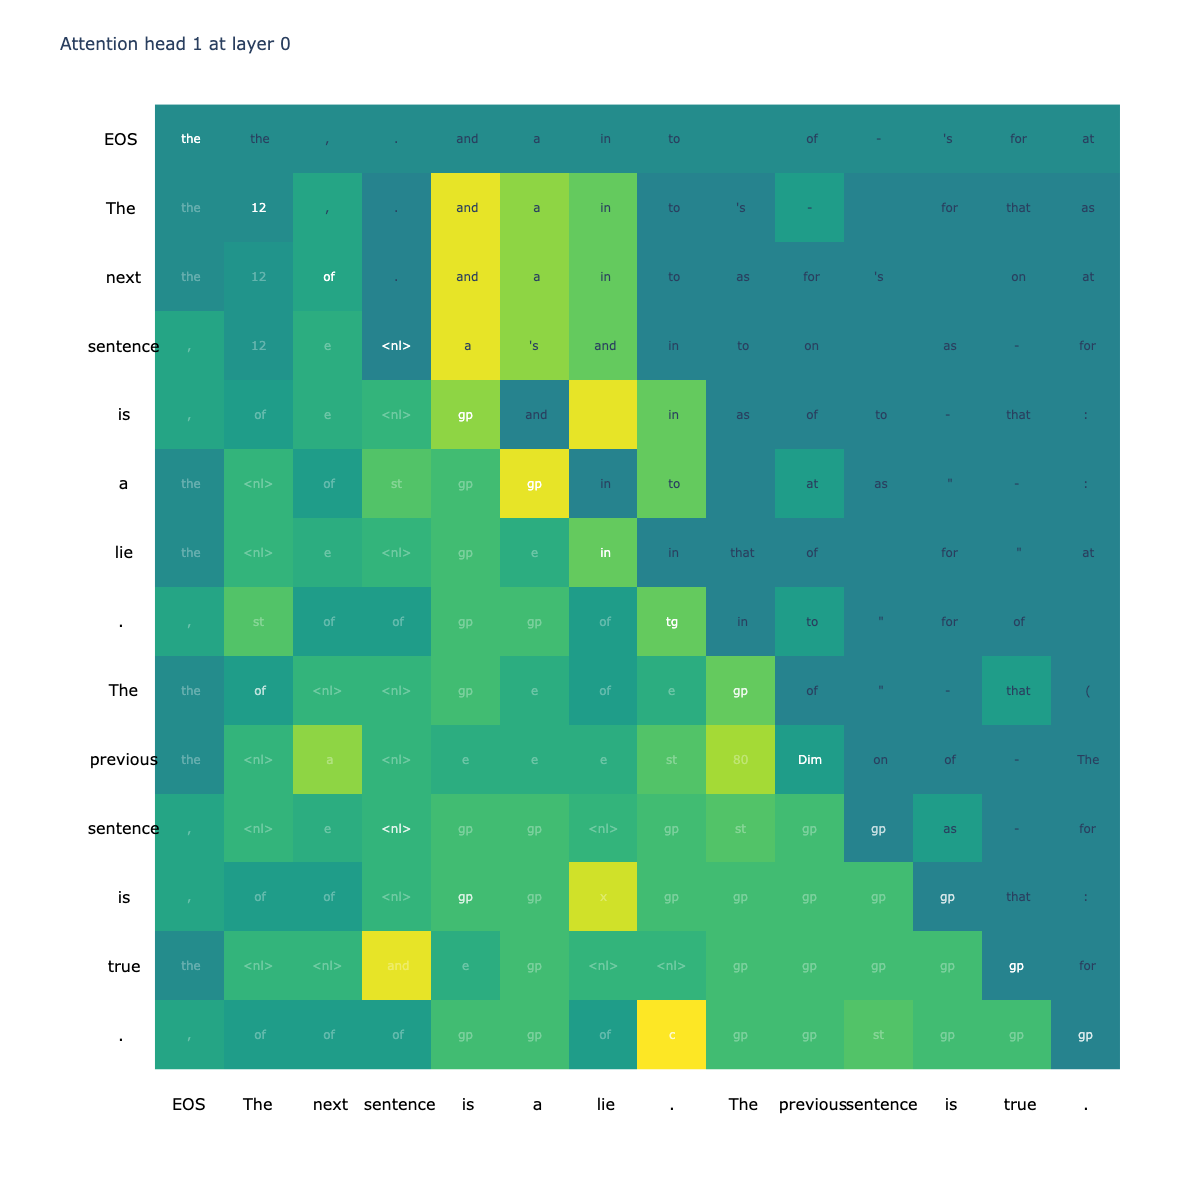

In [175]:
cache = run_prompt(model, "The next sentence is a lie. The previous sentence is true.")
fig, _ = plot_prompts(cache, 0, 1)
fig.show()

In [ ]:
random_tokens = torch.randint(0, 50257, (1, 18)).to(device)
random_prompt = model.to_str_tokens(random_tokens)
random_cache = run_prompt(model, ''.join(random_prompt))
fig, _ = plot_prompts(random_cache, 0, 0)
fig.show()

In [ ]:
data = []
for l in range(12):
    for h in range(12):
        fig, unique_tokens = plot_prompts(cache, l, h)
        fig.write_image(f'./images_4/layer_{l}_head_{h}.png')
        data.append({'layer': l, 'head': h, 'unique_tokens': unique_tokens})

import json

with open('./images_4/data.json', 'w') as f:
    json.dump(data, f)

In [ ]:
import pandas as pd

df = pd.read_json('./images_4/data.json')
df

In [ ]:
df['Unique_Tokens_Count'] = df['unique_tokens'].apply(lambda x: len(x))
df

In [ ]:
df_sorted = df.sort_values('Unique_Tokens_Count', ascending=False)
df_sorted


In [ ]:
from matplotlib import pyplot as plt

grouped_df = df.groupby('layer')

fig, ax = plt.subplots()
for layer, group in grouped_df:
    group.plot(x='head', y='Unique_Tokens_Count', kind='line', ax=ax, label=f'Layer {layer}')

plt.title('Unique Token Count by Head Index')
plt.xlabel('Head Index')
plt.ylabel('Unique Token Count')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()


In [ ]:
unique_tokens = set()
for tokens in df['unique_tokens']:
    unique_tokens.update(tokens)

print(f"Count of unique tokens: {len(unique_tokens)}")


In [ ]:
# Get the unique tokens for each head
head_tokens = df['unique_tokens']

seen = {}
duplicates = {}

for i, tokens in enumerate(head_tokens):
    for token in tokens:
        if token in seen:
            if token in duplicates:
                duplicates[token].append(i)
            else:
                duplicates[token] = [seen[token], i]
        else:
            seen[token] = i

from pprint import pprint

pprint(len(duplicates))

open questions
---

- are head tokens consistent across inputs?
- do head token counts remain consistent across inputs?
  - plot graphs for this
- which tokens are shared across all heads if any?
- are shared tokens common across inputs?
- how many tokens are used per row?

improvements
---
- plot Q in the top diagonal
- add border to cells over an attention score threshold
- plot resid stream predictions
- plot K instead of Q*K
  - if useful, add diagonal for Q*K at current token
- plot averaged inputs instead of individual prompts
- plot grid of attention token graphs
  - needs to run head calculations in parellel
- craft prompt for gpt to analyse patterns in attention tokens

In [ ]:
cache = run_prompt(model, "John was two years older than Mary. Who was born first? John was born before Mary")
fig, _ = plot_prompts(cache, 0, 0)
fig.show()

In [ ]:
cache = run_prompt(model, "Paris is the capital of France. London is the capital of England.")
fig, _ = plot_prompts(cache, 4, 11)
fig.show()